# Part 4: LLM Evaluation (Qwen2.5-3B via Ollama)

This notebook evaluates a **local LLM** (Qwen2.5-3B running via Ollama) on the same test set (518 samples) used for the fine-tuned transformer models, enabling a direct comparison.

**Prerequisites:**
- Ollama installed and running locally (`ollama serve`)
- Model pulled: `ollama pull qwen2.5:3b`

**Approach:**
| Variant | Description |
|---------|-------------|
| Zero-shot | System instruction + classify into negative/neutral/positive |
| Few-shot | 2 examples per class prepended to the prompt |

## 1. Setup & Data Loading

In [4]:
import sys
import json
import time
import warnings
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import requests
from tqdm import tqdm

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

from config.paths import PROJECT_ROOT, FIGURES_DIR, SPLITS_DIR
from config.params import LABEL_LIST, LABEL_TO_ID
from src.models.evaluator import ModelEvaluator
from src.visualization.training_viz import (
    plot_confusion_matrix,
    plot_per_class_metrics,
    plot_multi_model_comparison,
)

warnings.filterwarnings('ignore')

print(f"Project root: {PROJECT_ROOT}")

Project root: C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis


In [5]:
# Load test split
test_df = pd.read_csv(SPLITS_DIR / 'test.csv')
print(f"Test set: {len(test_df)} samples")
print(f"\nLabel distribution:")
print(test_df['label'].value_counts().sort_index())

test_texts = test_df['sentence'].tolist()
test_labels = test_df['label'].values

Test set: 518 samples

Label distribution:
label
0     63
1    322
2    133
Name: count, dtype: int64


In [6]:
# Verify Ollama is running and model is available
OLLAMA_URL = 'http://localhost:11434/api/generate'
MODEL_NAME = 'qwen2.5:3b'

try:
    resp = requests.get('http://localhost:11434/api/tags', timeout=5)
    models = [m['name'] for m in resp.json().get('models', [])]
    print(f"Ollama is running. Available models: {models}")
    assert MODEL_NAME in models, f"{MODEL_NAME} not found! Run: ollama pull {MODEL_NAME}"
    print(f"Using model: {MODEL_NAME}")
except requests.ConnectionError:
    raise RuntimeError("Ollama is not running. Start it with: ollama serve")

Ollama is running. Available models: ['qwen2.5:3b']
Using model: qwen2.5:3b


## 2. Prompt Design

In [7]:
SYSTEM_PROMPT = """You are a financial sentiment classifier. Your task is to classify financial news sentences into exactly one of three categories: negative, neutral, or positive.

Rules:
- Respond with ONLY one word: negative, neutral, or positive
- Do not include any explanation, punctuation, or extra text
- negative = pessimistic sentiment (losses, decline, problems, risks)
- neutral = factual statement without clear sentiment
- positive = optimistic sentiment (growth, profit, success, expansion)"""


FEW_SHOT_EXAMPLES = """Examples:
Text: "The company's revenue declined by 15% due to weakening demand."
Answer: negative

Text: "The board of directors will meet on March 15 to discuss the quarterly report."
Answer: neutral

Text: "Net profit surged 40% year-over-year, exceeding analyst expectations."
Answer: positive

Text: "Operating losses widened to EUR 2.3 million from EUR 1.1 million."
Answer: negative

Text: "The company operates in the Nordic markets."
Answer: neutral

Text: "Order intake grew significantly, reaching a new record level."
Answer: positive

"""


def build_prompt(text, few_shot=False):
    """Build the classification prompt for a given text."""
    prompt = SYSTEM_PROMPT + "\n\n"
    if few_shot:
        prompt += FEW_SHOT_EXAMPLES
    prompt += f'Text: "{text}"\nAnswer:'
    return prompt


# Preview
print("=== Zero-shot prompt ===")
print(build_prompt(test_texts[0], few_shot=False))
print("\n" + "=" * 60)
print("\n=== Few-shot prompt ===")
print(build_prompt(test_texts[0], few_shot=True))

=== Zero-shot prompt ===
You are a financial sentiment classifier. Your task is to classify financial news sentences into exactly one of three categories: negative, neutral, or positive.

Rules:
- Respond with ONLY one word: negative, neutral, or positive
- Do not include any explanation, punctuation, or extra text
- negative = pessimistic sentiment (losses, decline, problems, risks)
- neutral = factual statement without clear sentiment
- positive = optimistic sentiment (growth, profit, success, expansion)

Text: "Blyk is launching first in the UK market in mid-2007 , with other markets to follow ."
Answer:


=== Few-shot prompt ===
You are a financial sentiment classifier. Your task is to classify financial news sentences into exactly one of three categories: negative, neutral, or positive.

Rules:
- Respond with ONLY one word: negative, neutral, or positive
- Do not include any explanation, punctuation, or extra text
- negative = pessimistic sentiment (losses, decline, problems, risk

## 3. LLM Inference

In [8]:
VALID_LABELS = {'negative': 0, 'neutral': 1, 'positive': 2}


def parse_llm_response(raw_response):
    """
    Parse LLM response into a label ID.
    
    Returns:
        Tuple of (label_id, parsed_label_str, is_valid)
    """
    cleaned = raw_response.strip().lower().rstrip('.').strip()
    # Take only the first word in case model adds extra text
    first_word = cleaned.split()[0] if cleaned.split() else ''
    
    if first_word in VALID_LABELS:
        return VALID_LABELS[first_word], first_word, True
    
    # Fallback: check if any valid label appears anywhere in response
    for label, idx in VALID_LABELS.items():
        if label in cleaned:
            return idx, label, True
    
    # Unparseable — default to neutral
    return 1, f'UNPARSEABLE({cleaned[:50]})', False


def query_ollama(prompt, model=MODEL_NAME, temperature=0.0):
    """Send a prompt to Ollama and return the raw response text."""
    payload = {
        'model': model,
        'prompt': prompt,
        'stream': False,
        'options': {
            'temperature': temperature,
            'num_predict': 10,  # we only need one word
        }
    }
    resp = requests.post(OLLAMA_URL, json=payload, timeout=30)
    resp.raise_for_status()
    return resp.json()['response']


# Quick test
test_prompt = build_prompt("Revenue increased by 25% year-over-year.", few_shot=False)
test_response = query_ollama(test_prompt)
print(f"Test response: '{test_response}'")
print(f"Parsed: {parse_llm_response(test_response)}")

Test response: 'positive'
Parsed: (2, 'positive', True)


In [9]:
# Run zero-shot inference on all test samples
USE_FEW_SHOT = False  # Set to True to use few-shot prompting

llm_predictions = []
llm_raw_responses = []
unparseable_indices = []

start_time = time.time()

for i, text in enumerate(tqdm(test_texts, desc="LLM inference")):
    prompt = build_prompt(text, few_shot=USE_FEW_SHOT)
    
    try:
        raw_response = query_ollama(prompt)
    except Exception as e:
        raw_response = f'ERROR: {e}'
    
    label_id, label_str, is_valid = parse_llm_response(raw_response)
    
    llm_predictions.append(label_id)
    llm_raw_responses.append(raw_response.strip())
    
    if not is_valid:
        unparseable_indices.append(i)

elapsed = time.time() - start_time

llm_preds = np.array(llm_predictions)

print(f"\nInference completed in {elapsed:.1f}s ({elapsed/len(test_texts):.2f}s per sample)")
print(f"Predictions shape: {llm_preds.shape}")
print(f"Unique predictions: {np.unique(llm_preds, return_counts=True)}")
print(f"Unparseable responses: {len(unparseable_indices)}")

LLM inference: 100%|██████████| 518/518 [21:49<00:00,  2.53s/it]


Inference completed in 1309.5s (2.53s per sample)
Predictions shape: (518,)
Unique predictions: (array([0, 1, 2]), array([ 64, 390,  64]))
Unparseable responses: 0


In [10]:
# Show unparseable responses if any
if unparseable_indices:
    print(f"Unparseable responses ({len(unparseable_indices)} total):")
    print("-" * 60)
    for idx in unparseable_indices[:20]:  # show first 20
        print(f"  [{idx}] Response: '{llm_raw_responses[idx]}'")
        print(f"        Text: '{test_texts[idx][:80]}...'")
        print()
else:
    print("All responses were parsed successfully.")

All responses were parsed successfully.


## 4. Metrics & Visualization

In [11]:
evaluator = ModelEvaluator(label_names=LABEL_LIST)

llm_metrics = evaluator.compute_metrics(llm_preds, test_labels)

variant = "Few-shot" if USE_FEW_SHOT else "Zero-shot"
print("=" * 60)
print(f"Qwen2.5-3B ({variant}) - Test Set Results")
print("=" * 60)
print(f"Accuracy:         {llm_metrics['accuracy']:.4f}")
print(f"F1 (weighted):    {llm_metrics['f1_weighted']:.4f}")
print(f"F1 (macro):       {llm_metrics['f1_macro']:.4f}")
print(f"Precision (wtd):  {llm_metrics['precision_weighted']:.4f}")
print(f"Recall (wtd):     {llm_metrics['recall_weighted']:.4f}")
print(f"\nClassification Report:")
print(evaluator.get_classification_report(llm_preds, test_labels))

Qwen2.5-3B (Zero-shot) - Test Set Results
Accuracy:         0.8185
F1 (weighted):    0.7997
F1 (macro):       0.7805
Precision (wtd):  0.8332
Recall (wtd):     0.8185

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.89      0.88        63
     neutral       0.79      0.96      0.87       322
    positive       0.91      0.44      0.59       133

    accuracy                           0.82       518
   macro avg       0.86      0.76      0.78       518
weighted avg       0.83      0.82      0.80       518



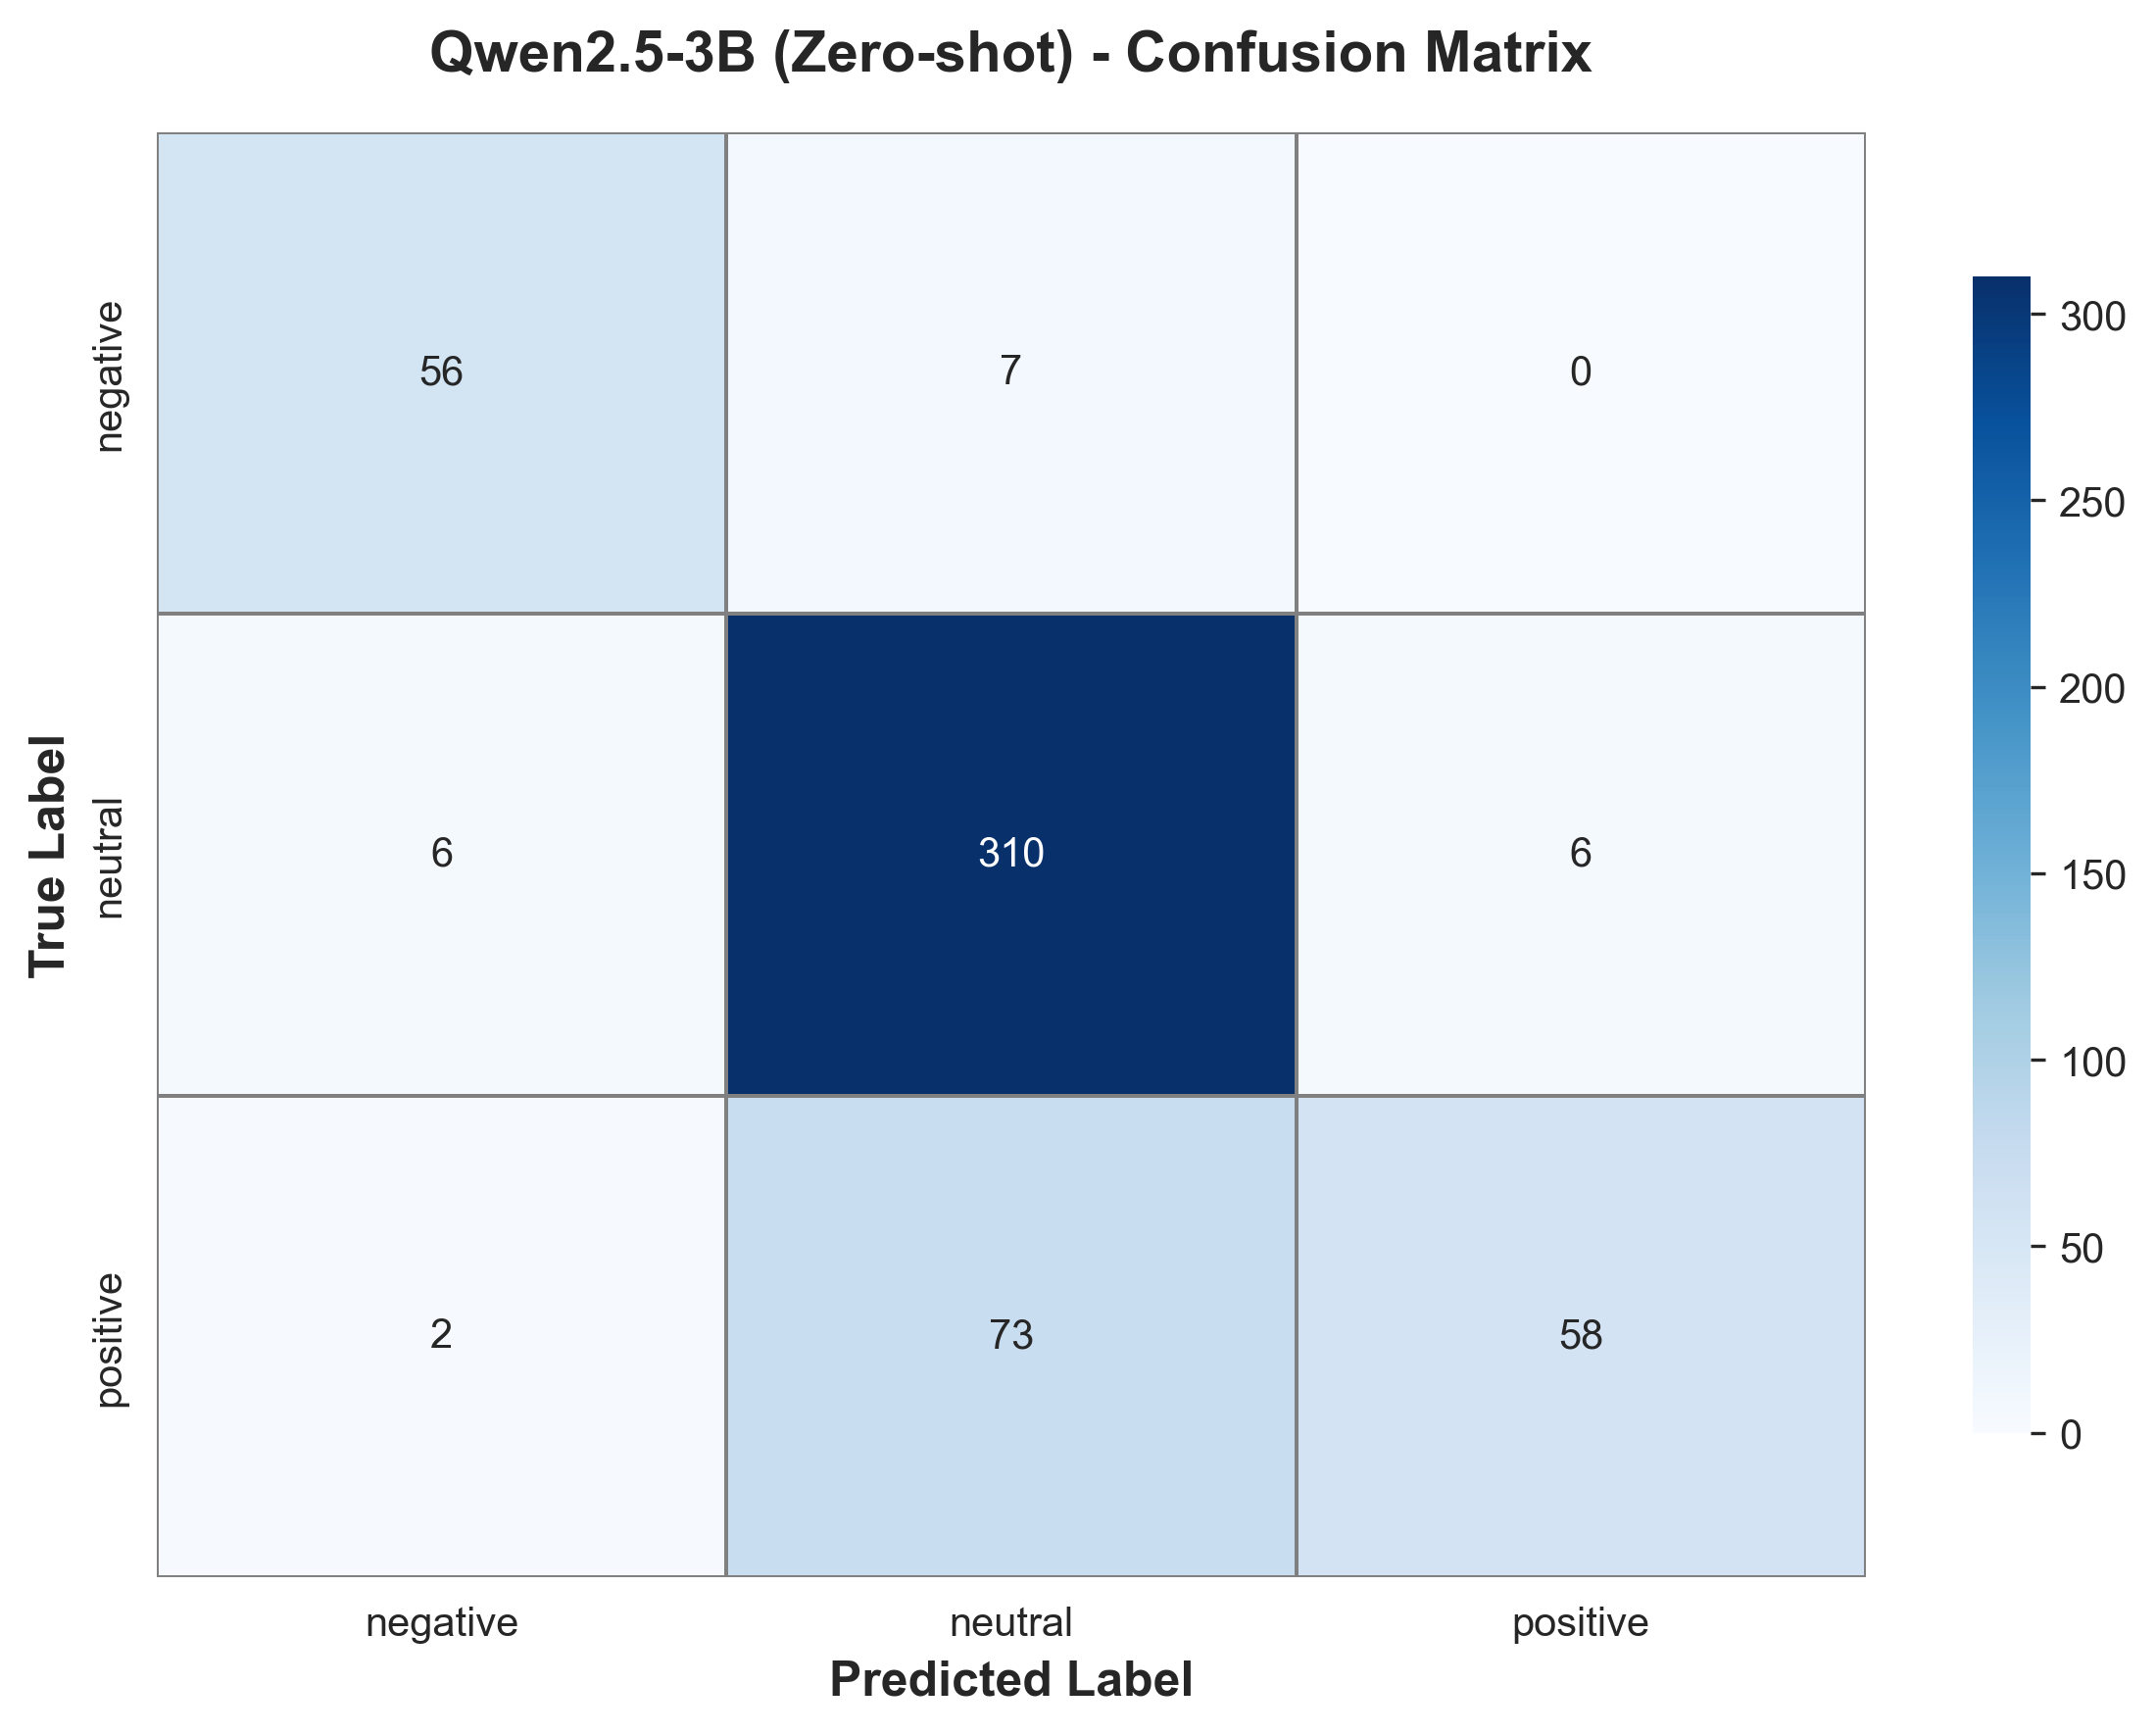

(<Figure size 2400x1800 with 2 Axes>,
 <Axes: title={'center': 'Qwen2.5-3B (Zero-shot) - Confusion Matrix'}, xlabel='Predicted Label', ylabel='True Label'>)

In [12]:
# Confusion matrix
cm_llm = evaluator.get_confusion_matrix(llm_preds, test_labels)
plot_confusion_matrix(
    cm_llm, LABEL_LIST,
    save_path=str(FIGURES_DIR / 'llm_confusion_matrix.png'),
    title=f'Qwen2.5-3B ({variant}) - Confusion Matrix'
)

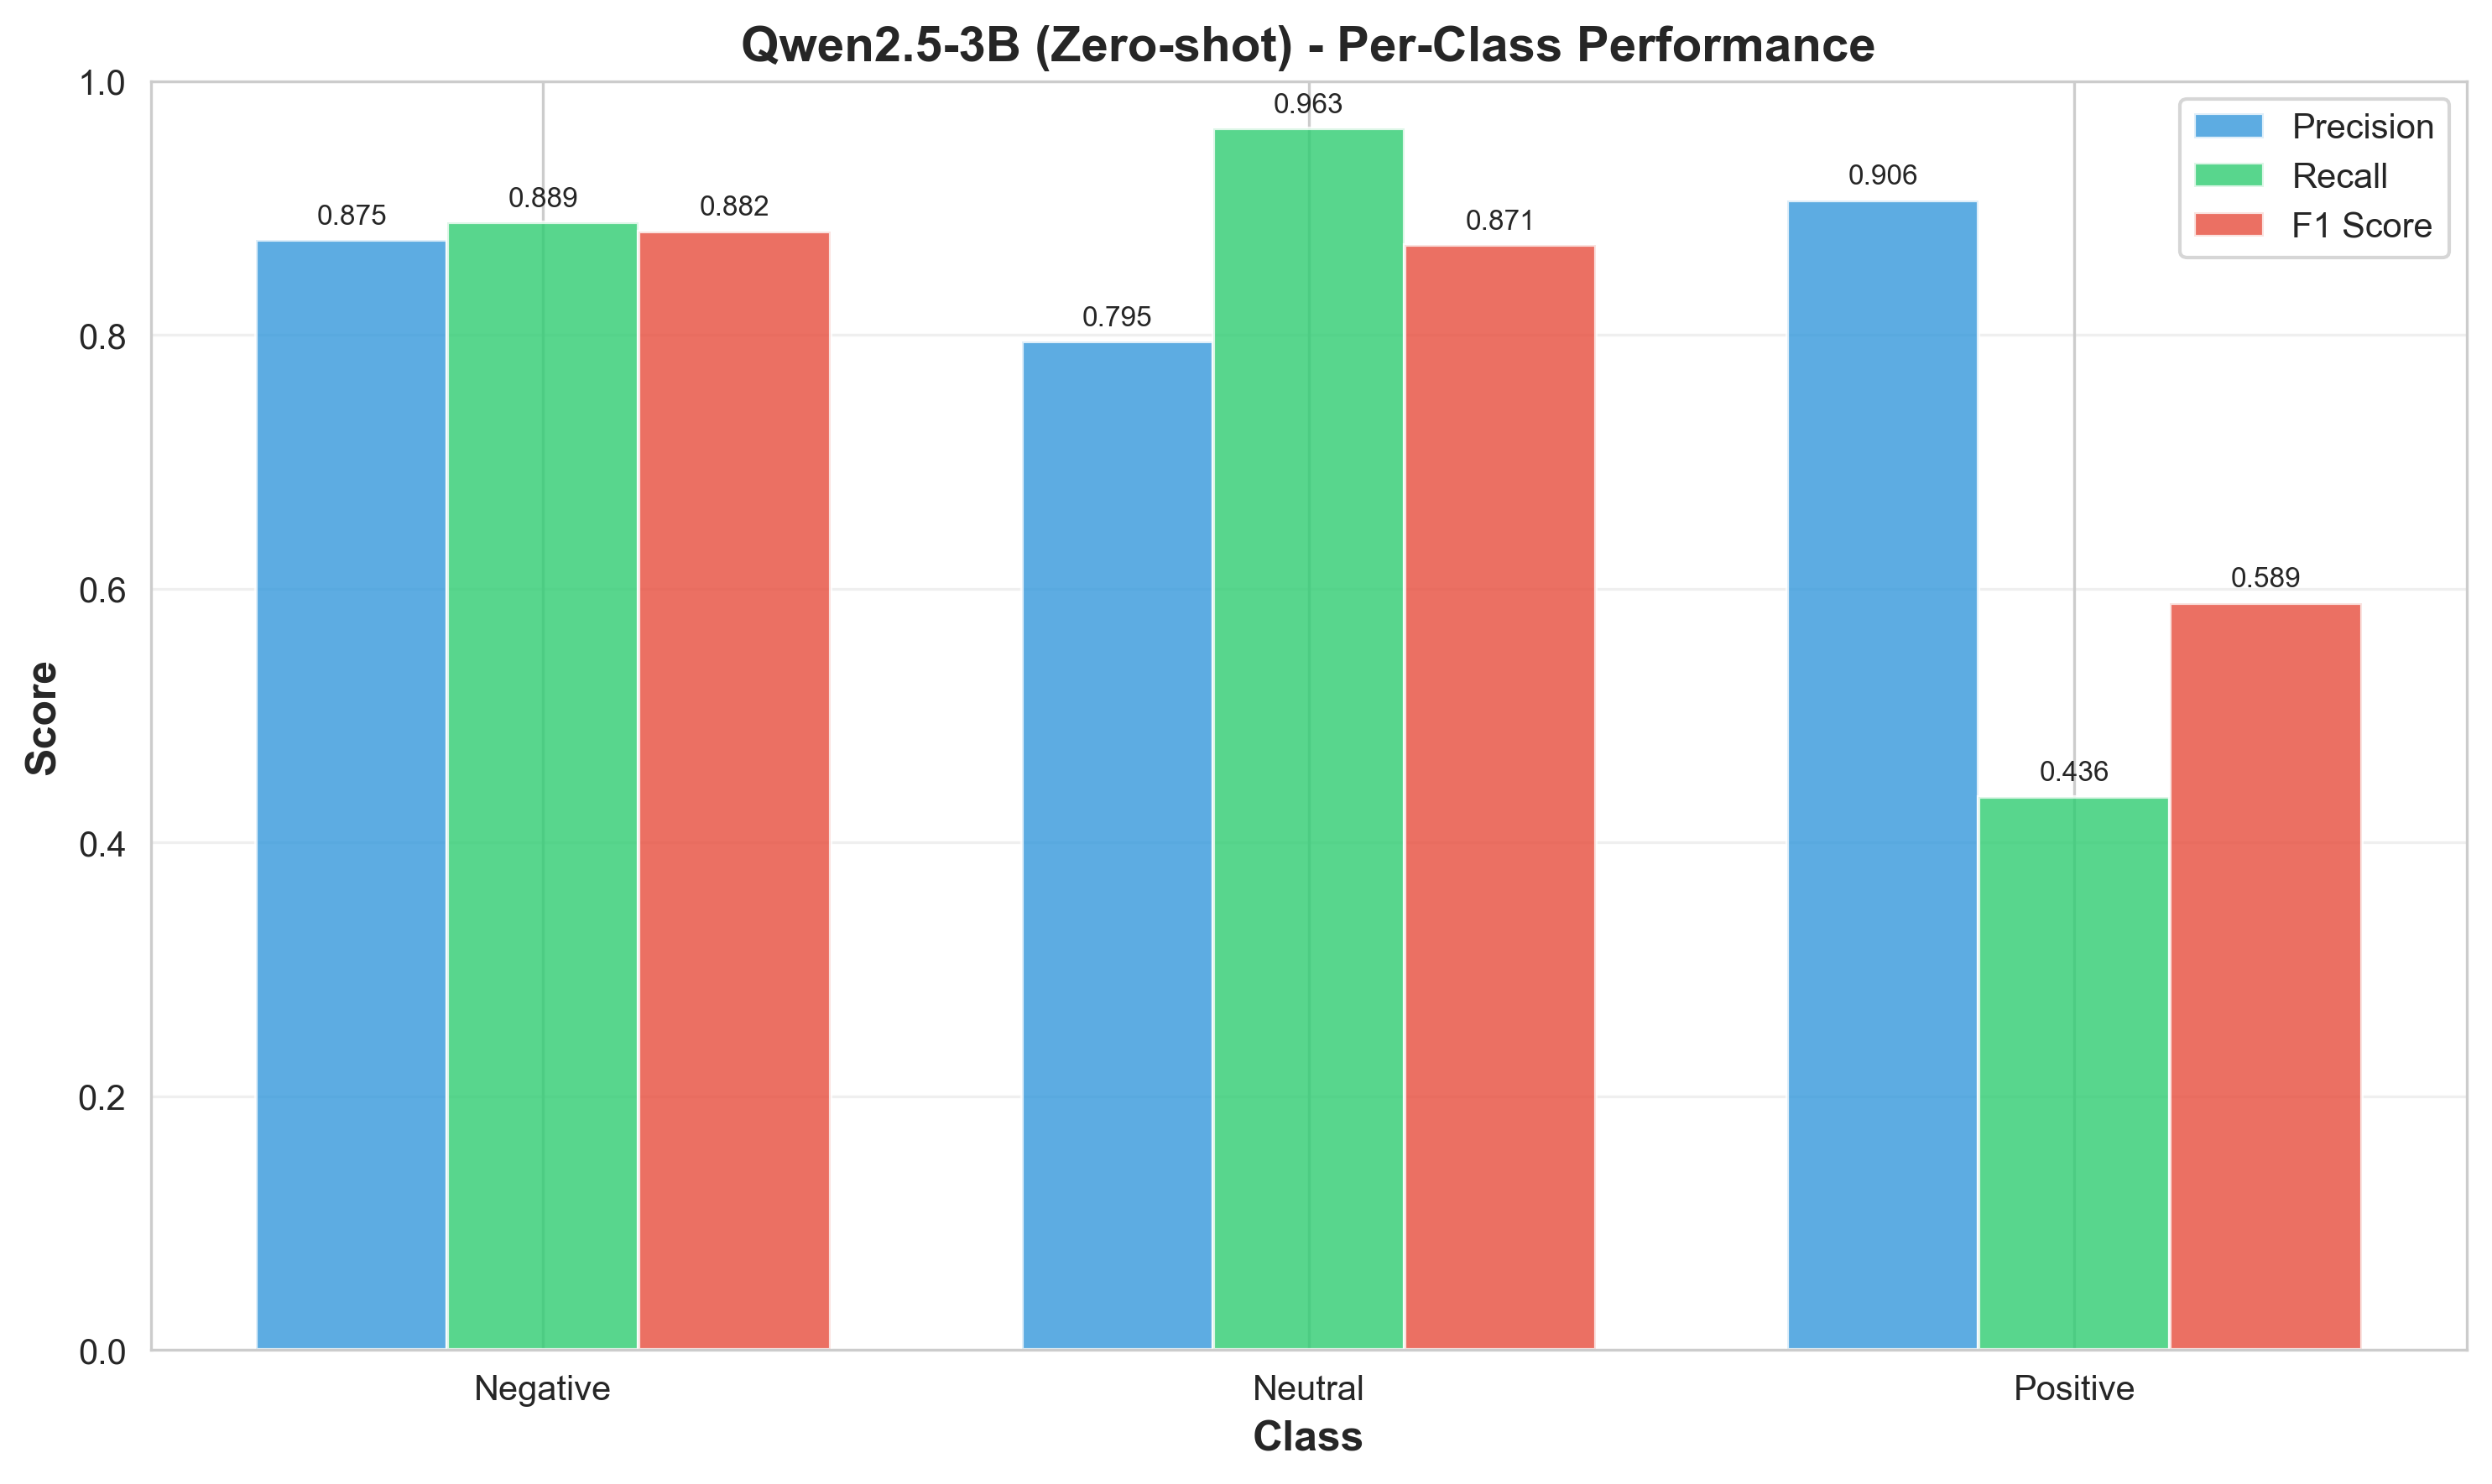

(<Figure size 3000x1800 with 1 Axes>,
 <Axes: title={'center': 'Qwen2.5-3B (Zero-shot) - Per-Class Performance'}, xlabel='Class', ylabel='Score'>)

In [13]:
# Per-class metrics
plot_per_class_metrics(
    llm_metrics, LABEL_LIST,
    save_path=str(FIGURES_DIR / 'llm_per_class.png'),
    title=f'Qwen2.5-3B ({variant}) - Per-Class Performance'
)

## 5. Comparison with All Models

In [14]:
# Load results from experiments/results.json
results_path = PROJECT_ROOT / 'experiments' / 'results.json'
with open(results_path, 'r') as f:
    results_data = json.load(f)

# Build metrics dict for all previous models
model_name_map = {
    'finbert-base': 'FinBERT (base)',
    'roberta-zero-shot': 'RoBERTa (zero-shot)',
    'finbert': 'FinBERT (fine-tuned)',
    'roberta-base': 'RoBERTa (fine-tuned)',
}

all_metrics = {}
for exp in results_data['experiments']:
    name = model_name_map.get(exp['model'], exp['model'])
    r = exp['results']
    all_metrics[name] = {
        'accuracy': r['test_accuracy'],
        'precision_weighted': r['test_precision'],
        'recall_weighted': r['test_recall'],
        'f1_weighted': r['test_f1_weighted'],
        'f1_macro': r['test_f1_macro'],
        'f1_per_class': r['per_class_f1'],
    }

# Add LLM results
all_metrics[f'Qwen2.5-3B ({variant})'] = llm_metrics

# Build comparison table
metric_keys = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro']
metric_labels = ['Accuracy', 'Precision (wtd)', 'Recall (wtd)', 'F1 (weighted)', 'F1 (macro)']

comparison_rows = []
for key, label in zip(metric_keys, metric_labels):
    row = {'Metric': label}
    for model_name, m in all_metrics.items():
        row[model_name] = f"{m.get(key, 0.0):.4f}"
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows)
print("=" * 110)
print("5-Model Comparison on Test Set")
print("=" * 110)
print(comparison_df.to_string(index=False))

5-Model Comparison on Test Set
         Metric RoBERTa (fine-tuned) FinBERT (fine-tuned) FinBERT (base) RoBERTa (zero-shot) Qwen2.5-3B (Zero-shot)
       Accuracy               0.9112               0.9556         0.9479              0.3996                 0.8185
Precision (wtd)               0.9280               0.9602         0.9517              0.7670                 0.8332
   Recall (wtd)               0.9112               0.9556         0.9479              0.3996                 0.8185
  F1 (weighted)               0.9138               0.9563         0.9486              0.2731                 0.7997
     F1 (macro)               0.9093               0.9502         0.9354              0.4148                 0.7805


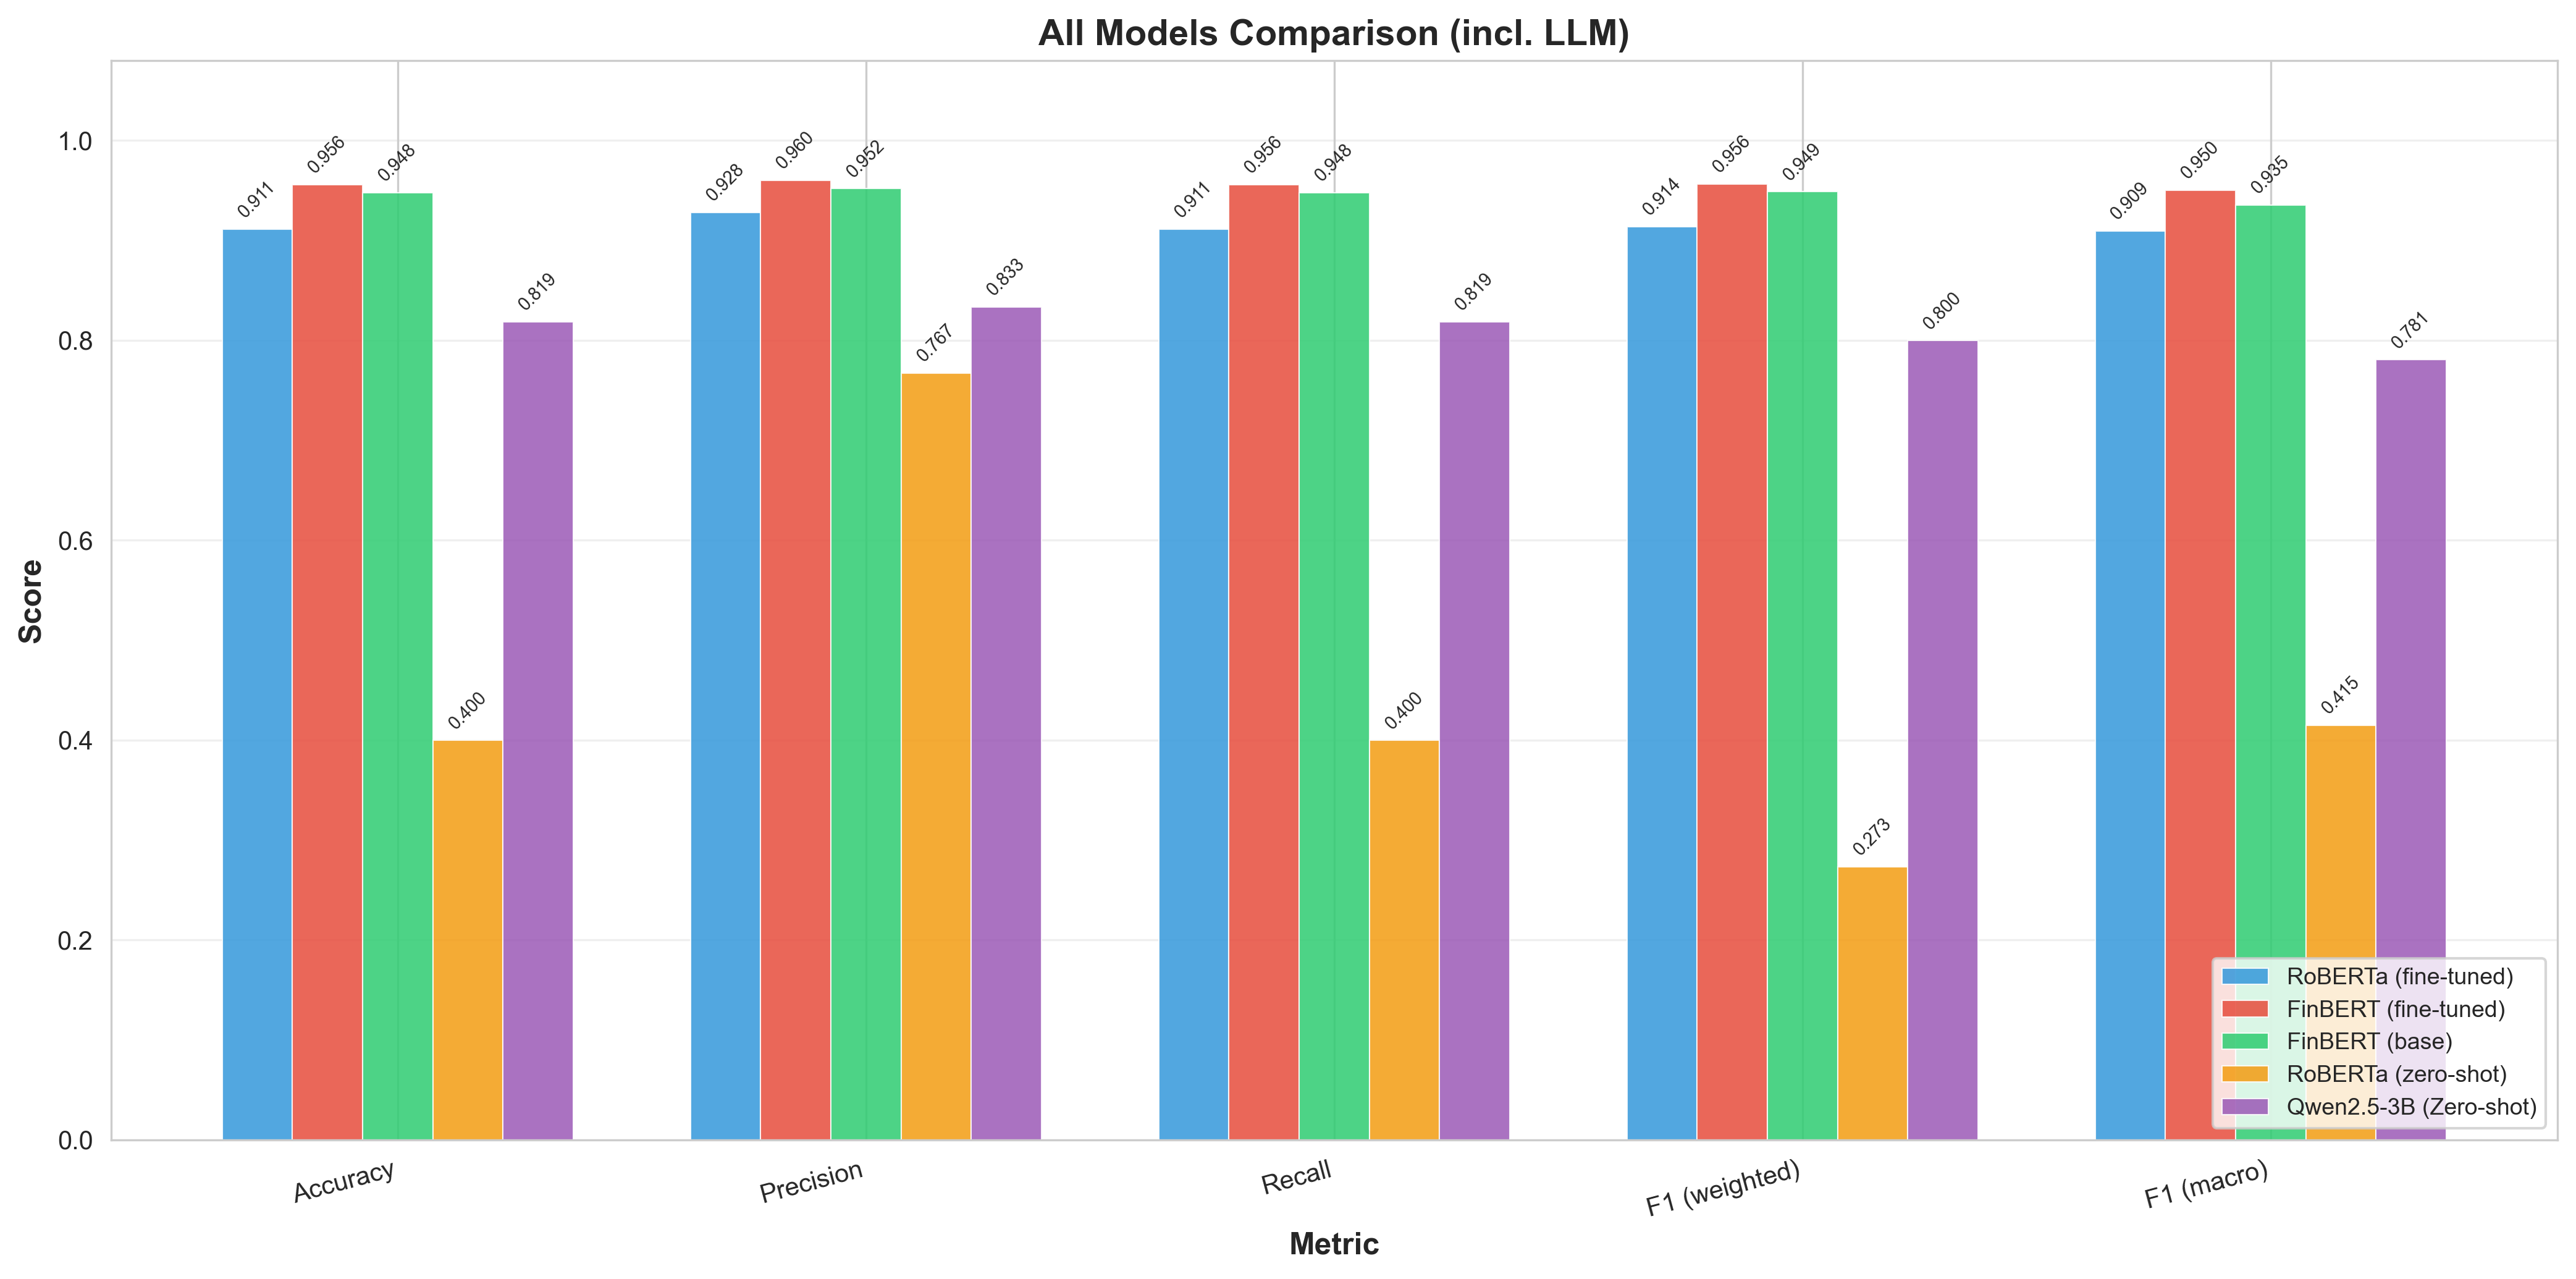

(<Figure size 4200x2100 with 1 Axes>,
 <Axes: title={'center': 'All Models Comparison (incl. LLM)'}, xlabel='Metric', ylabel='Score'>)

In [15]:
# Multi-model bar chart (all 5 models)
plot_multi_model_comparison(
    all_metrics,
    save_path=str(FIGURES_DIR / 'llm_multi_model_comparison.png'),
    title='All Models Comparison (incl. LLM)'
)

## 6. Error Analysis

In [16]:
# Error analysis
error_analysis = evaluator.analyze_errors(
    texts=test_texts,
    predictions=llm_preds,
    labels=test_labels,
    top_k=15
)

print(f"Total errors: {error_analysis['total_errors']} / {error_analysis['total_samples']}")
print(f"Error rate: {error_analysis['error_rate']:.2f}%")
print(f"\nError type distribution:")
for error_type, count in error_analysis['error_type_counts'].items():
    print(f"  {error_type}: {count}")

print("\nError patterns:")
for pattern in evaluator.get_error_patterns(error_analysis):
    print(f"  - {pattern}")

Total errors: 94 / 518
Error rate: 18.15%

Error type distribution:
  positive -> neutral: 73
  negative -> neutral: 7
  neutral -> positive: 6
  neutral -> negative: 6
  positive -> negative: 2

Error patterns:
  - Most common error: 'positive -> neutral' (73 occurrences, 77.7% of all errors)
  - Errors involving 'neutral' class: 92 (97.9% of all errors)
  - Sentiment reversal errors (positive <-> negative): 2 (2.1% of all errors)


In [17]:
# Show sample errors
print("Sample misclassified texts:")
print("=" * 80)
for err in error_analysis['top_errors'][:10]:
    print(f"  True: {err['true_label']:10s}  Pred: {err['predicted_label']:10s}")
    print(f"  Text: {err['text'][:100]}")
    print(f"  LLM response: '{llm_raw_responses[err['index']]}'")
    print()

Sample misclassified texts:
  True: positive    Pred: neutral   
  Text: Acquisitions have been made and businesses have been well integrated .
  LLM response: 'neutral'

  True: positive    Pred: neutral   
  Text: Operating profit for the nine-month period increased from EUR3 .1 m and net sales increased from EUR
  LLM response: 'neutral'

  True: positive    Pred: neutral   
  Text: 1 February 2011 - Finnish textile and clothing company Marimekko Oyj HEL : MMO1V said today its prel
  LLM response: 'neutral'

  True: positive    Pred: neutral   
  Text: The company 's operating income ( EBIT ) totalled EUR 0.0 mn , up from EUR -0.3 mn year-on-year .
  LLM response: 'neutral'

  True: positive    Pred: neutral   
  Text: Finnish Aktia Group 's operating profit rose to EUR 17.5 mn in the first quarter of 2010 from EUR 8.
  LLM response: 'neutral'

  True: positive    Pred: neutral   
  Text: The fair value of the investment properties totaled EUR 2,534.9 mn , up from EUR 2,455.1 mn in 

In [18]:
# Compare LLM errors vs FinBERT fine-tuned errors
# Load FinBERT fine-tuned predictions if available, otherwise compare at aggregate level

llm_correct = (llm_preds == test_labels)

# Find FinBERT fine-tuned experiment results for context
finbert_ft = all_metrics.get('FinBERT (fine-tuned)', {})

print("LLM vs FinBERT (fine-tuned) — Aggregate Comparison")
print("=" * 60)
print(f"{'Metric':<20s} {'Qwen2.5-3B':>12s} {'FinBERT FT':>12s} {'Diff':>10s}")
print("-" * 60)
for key, label in zip(metric_keys, metric_labels):
    llm_val = llm_metrics.get(key, 0.0)
    ft_val = finbert_ft.get(key, 0.0)
    diff = llm_val - ft_val
    print(f"{label:<20s} {llm_val:>12.4f} {ft_val:>12.4f} {diff:>+10.4f}")

LLM vs FinBERT (fine-tuned) — Aggregate Comparison
Metric                 Qwen2.5-3B   FinBERT FT       Diff
------------------------------------------------------------
Accuracy                   0.8185       0.9556    -0.1371
Precision (wtd)            0.8332       0.9602    -0.1270
Recall (wtd)               0.8185       0.9556    -0.1371
F1 (weighted)              0.7997       0.9563    -0.1566
F1 (macro)                 0.7805       0.9502    -0.1697


## 7. Save Results

In [19]:
# Add LLM experiment to results.json
llm_experiment = {
    'experiment_id': 5,
    'model': 'qwen2.5-3b',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'approach': f'llm-{variant.lower()}',
        'model_name': MODEL_NAME,
        'runtime': 'ollama-local',
        'temperature': 0.0,
        'few_shot': USE_FEW_SHOT,
        'num_examples_per_class': 2 if USE_FEW_SHOT else 0,
    },
    'results': {
        'test_accuracy': float(llm_metrics['accuracy']),
        'test_precision': float(llm_metrics['precision_weighted']),
        'test_recall': float(llm_metrics['recall_weighted']),
        'test_f1_weighted': float(llm_metrics['f1_weighted']),
        'test_f1_macro': float(llm_metrics['f1_macro']),
        'per_class_f1': [float(x) for x in llm_metrics['f1_per_class']],
        'unparseable_count': len(unparseable_indices),
        'inference_time_seconds': round(elapsed, 1),
    }
}

# Remove old LLM experiment if re-running
results_data['experiments'] = [
    exp for exp in results_data['experiments']
    if exp['experiment_id'] != 5
]
results_data['experiments'].append(llm_experiment)

# Save
with open(results_path, 'w') as f:
    json.dump(results_data, f, indent=2)

print(f"Results saved to {results_path}")
print(f"Total experiments: {len(results_data['experiments'])}")

Results saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\experiments\results.json
Total experiments: 5


In [20]:
# Save raw LLM responses for reproducibility
llm_results_df = pd.DataFrame({
    'sentence': test_texts,
    'true_label': test_labels,
    'predicted_label': llm_preds,
    'raw_response': llm_raw_responses,
    'correct': llm_preds == test_labels,
})

llm_output_path = PROJECT_ROOT / 'outputs' / 'reports' / 'llm_predictions.csv'
llm_results_df.to_csv(llm_output_path, index=False)
print(f"Raw predictions saved to {llm_output_path}")

Raw predictions saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\reports\llm_predictions.csv


In [21]:
print("\n" + "=" * 70)
print("Notebook 04 complete.")
print("=" * 70)
print("\nSaved figures:")
for fig_name in [
    'llm_confusion_matrix.png',
    'llm_per_class.png',
    'llm_multi_model_comparison.png',
]:
    path = FIGURES_DIR / fig_name
    status = 'OK' if path.exists() else 'MISSING'
    print(f"  [{status}] {fig_name}")

print(f"\nSaved data:")
print(f"  [OK] experiments/results.json (experiment_id=5)")
print(f"  [OK] outputs/reports/llm_predictions.csv")


Notebook 04 complete.

Saved figures:
  [OK] llm_confusion_matrix.png
  [OK] llm_per_class.png
  [OK] llm_multi_model_comparison.png

Saved data:
  [OK] experiments/results.json (experiment_id=5)
  [OK] outputs/reports/llm_predictions.csv
